In [0]:
#MNIST: Handwritten image dataset

In [0]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [0]:

seed = 20
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [0]:
class Net(nn.Module):
    def __init__(self, activation): #We added a new parameter called activation with the aim to generalize the function, using it for each activation function
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,20,5,1)  #[w,h,c,n] =[width, hight, channels, batch dimension]   
        # input[:,:,0,0] it will give me the first image of the first channel of the batch.
        # input[5,:,0,0] it will give me  the first image of the first channel of the batch at the 6th position of the width
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.fc1 = nn.Linear(4*4*50,500)
        self.fc2 = nn.Linear(500,10)
        self.activation = activation    
    def forward(self,x):
        x = self.activation(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.activation(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
      

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    return validation_loss

In [0]:
train_batch_size = 128

mnist_mean = 0.1307
mnist_stddev = 0.3081
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=train_batch_size,
    shuffle=True)

valid_batch_size = 1000
valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data',
                   train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mnist_mean,), (mnist_stddev,))
                   ])),
    batch_size=valid_batch_size,
    shuffle=True)

In [0]:
 def hyperparameter(activation1,activation2,activation3):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model1 = Net(activation1).to(device)
  model2 = Net(activation2).to(device)
  model3 = Net(activation3).to(device)
  optimizer1 = optim.SGD(model1.parameters(), lr=0.01, momentum=0.5)
  optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.5)
  optimizer3 = optim.SGD(model3.parameters(), lr=0.01, momentum=0.5)

#In this part of the code we are readjusting the parameters and calculating the Average Losses and the Accuracy for each Activation Function (relu,tanh,sigmoid)
  train_losses1 = []
  valid_losses1 = []
  valid_x1 = []
  num_epochs1 = 10
  
  print("\nRELU FUNCTION:\n")

  for epoch in range(1, num_epochs1 + 1):
      epoch_losses1 = train(80, model1, device, train_loader, optimizer1, epoch)
      train_losses1.extend(epoch_losses1)
      valid_loss1 = validate(model1, device, valid_loader)
      valid_losses1.append([valid_loss1])
      valid_x1.append(len(train_losses1) - 1)

  train_losses2 = []
  valid_losses2 = []
  valid_x2 = []
  num_epochs2 = 10
  print("\nTANH FUNCTION:\n")

  for epoch in range(1, num_epochs2 + 1):
      epoch_losses2 = train(80, model2, device, train_loader, optimizer2, epoch)
      train_losses2.extend(epoch_losses2)
      valid_loss2 = validate(model2, device, valid_loader)
      valid_losses2.append([valid_loss2])
      valid_x2.append(len(train_losses2) - 1)
  
  train_losses3 = []
  valid_losses3 = []
  valid_x3 = []
  num_epochs3 = 10
  print("\nSIGMOID FUNCTION:\n")

  for epoch in range(1, num_epochs3 + 1):
      epoch_losses3 = train(80, model3, device, train_loader, optimizer3, epoch)
      train_losses3.extend(epoch_losses3)
      valid_loss3 = validate(model3, device, valid_loader)
      valid_losses3.append([valid_loss3])
      valid_x3.append(len(train_losses3) - 1)

  plt.gcf().clear()
  plt.plot(train_losses1, 'b-',train_losses2, 'g-',train_losses3, 'r-')
  plt.show()
  plt.plot(valid_x1, valid_losses1, 'b-',valid_x2, valid_losses2, 'g-',valid_x3, valid_losses3, 'r-')
  plt.show()
  
  

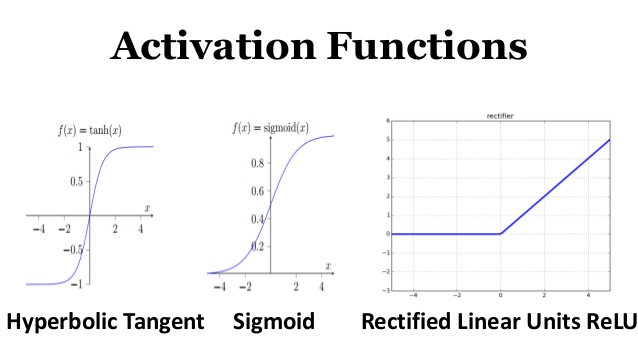

**HIPERBOLIC TANGENT:**

This function acts like a classifier betwen {-1,+1}.

**SIGMOID:**

This function acts like a classifier betwen {0,+1}.

**RELU:**

This function acts like a classifier betwen {0,x}.

f(x) = 0 for x<0

f(x) = x for x>=0


RELU FUNCTION:

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300098
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.488531
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.343269
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.281262
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.203197
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.164501

Validation set: Average loss: 0.1600, Accuracy: 9539/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.203579
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.189171
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.091127
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.088888
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.229928
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.061517

Validation set: Average loss: 0.1006, Accuracy: 9687/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.120779
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.105823
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.153203
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.051048
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.064875
Train Epoch: 3

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.138789
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.573562
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.513853
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.417482
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.302171

Validation set: Average loss: 0.2860, Accuracy: 9234/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.269642
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.369722
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.340723
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.201613
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.261898
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.223548

Validation set: Average loss: 0.1771, Accuracy: 9477/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.110933
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.164083
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.107279
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.197699
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.180341
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.159210

Validation set: Average l

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.294940
Train Epoch: 1 [20480/60000 (34%)]	Loss: 2.312640
Train Epoch: 1 [30720/60000 (51%)]	Loss: 2.305156
Train Epoch: 1 [40960/60000 (68%)]	Loss: 2.312053
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.296314

Validation set: Average loss: 2.3012, Accuracy: 974/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.294261
Train Epoch: 2 [10240/60000 (17%)]	Loss: 2.307250
Train Epoch: 2 [20480/60000 (34%)]	Loss: 2.331528
Train Epoch: 2 [30720/60000 (51%)]	Loss: 2.304528
Train Epoch: 2 [40960/60000 (68%)]	Loss: 2.306024
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.311805

Validation set: Average loss: 2.3011, Accuracy: 1135/10000 (11%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.309586
Train Epoch: 3 [10240/60000 (17%)]	Loss: 2.291547
Train Epoch: 3 [20480/60000 (34%)]	Loss: 2.304524
Train Epoch: 3 [30720/60000 (51%)]	Loss: 2.289962
Train Epoch: 3 [40960/60000 (68%)]	Loss: 2.316182
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.288729

Validation set: Average lo

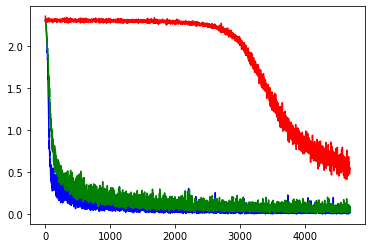

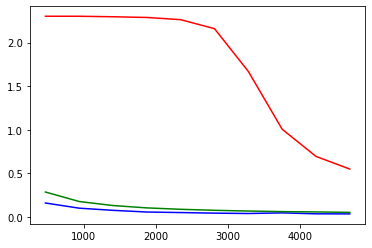

In [0]:
hyperparameter(F.relu,F.tanh,F.sigmoid)



---
**AVERAGE LOSSES AND ACCURACY SUMMARY:**

---
**RELU**: Average loss: 0.0349, Accuracy: 9885/10000 (99%)

---
**TANH**: Average loss: 0.0525, Accuracy: 9844/10000 (98%)

---
**SIGMOID**: Average loss: 0.5493, Accuracy: 8508/10000 (85%)

---










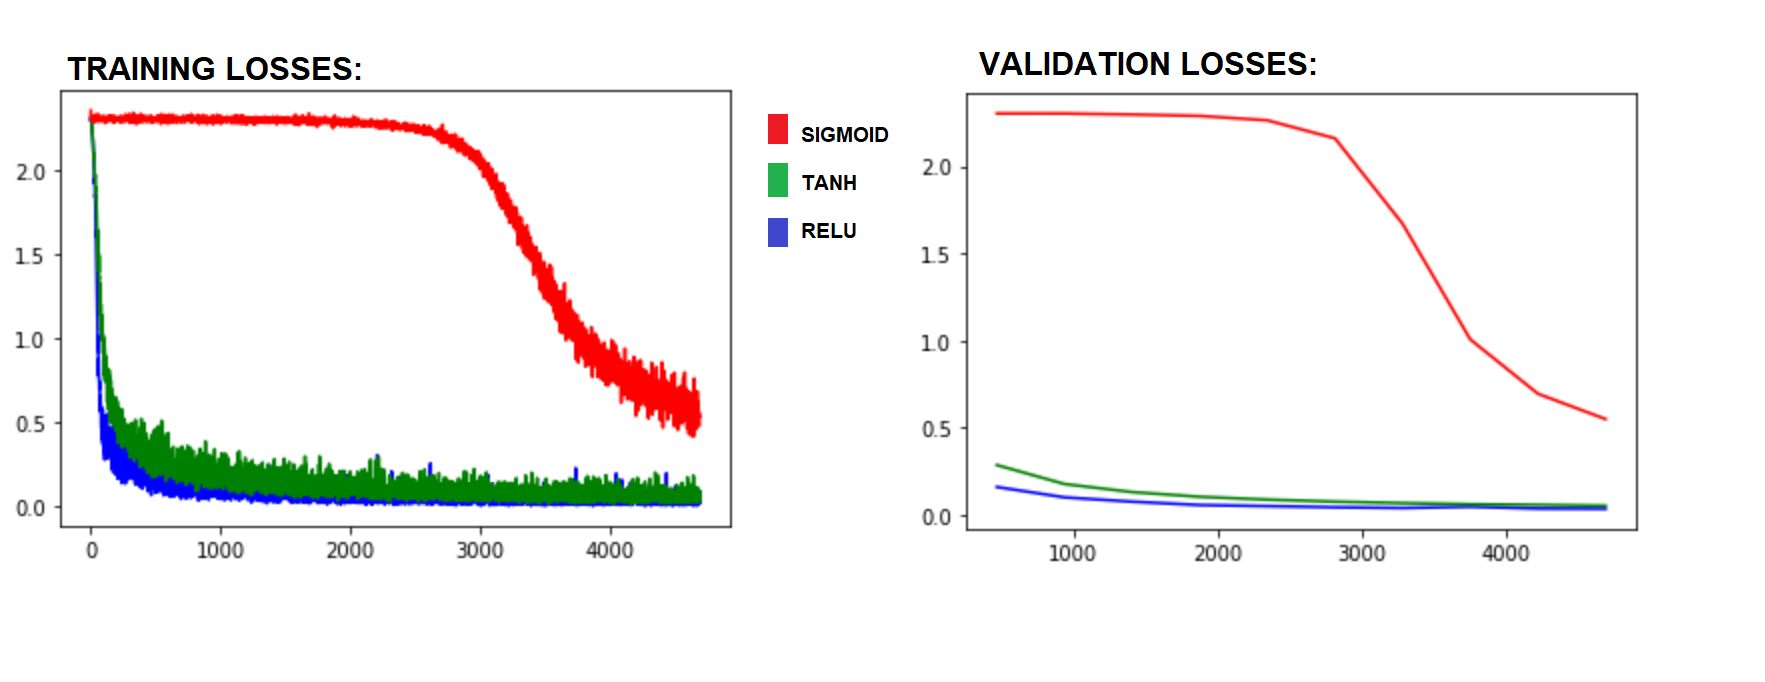

**CONCLUSIONS:**

1: The activation function which introduces less training losses is the RELU, followed by the Tanh. The sigmoid function is the one that have less accuracy.

2: The sigmoid activation function is very particular because it is affected by the vanishing gradient problem. To understand this problem, we have to take a look in the first derivative of the sigmoid function.

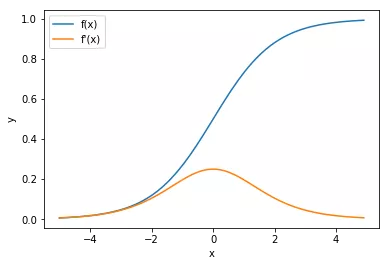

3: Due to the smaller values in the edges of the derivative function, the estimated parameters in the backpropagation (weights and bias) are vanished. It causes a reduction in the training efficiency.

4: Sigmoid function has low convergence, this fact means that it needs more examples to be well trained.

5: To have a better result, one possible solution is the use of the tanh activation function. Tanh function helps to have a better optimization compared with the optimization obtined with the sigmoid function. One reason is that tanh function is centrated in the zero. This fact helps to have a derivative function with higher values.

6: To solve the vanishing gradient problem, it is used the ReLu activation function. Almost all deep learning models use ReLu nowadays.

7: One adventage of using ReLu function is that it doesn't activate all the neurons at the same time because it converts to zero the negative inputs. This means that in a given time only a few neurons are working, obtaining a more efficient network.

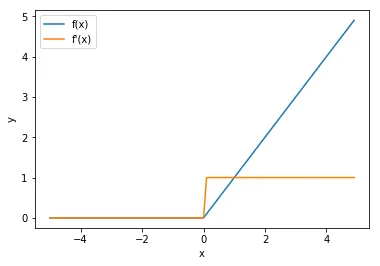

8: As you can see, the first derivative of the ReLu function is 0 or 1. This fact is very useful during the backpropagation because it doesn't degradate the result.

9: One problem that ReLu function has is that the negative values are killed. It causes that its values can't be updated. For that, a better function that is used instead of ReLu is the Leaky ReLu, which doesn't eliminate the negative values.


